<a href="https://colab.research.google.com/github/cubecloud/fool_game/blob/feature-04-rewrite-main-circle/fool_game_and_q_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### New Import

In [2]:
!pip install git+https://github.com/cubecloud/fool_game.git@feature-04-rewrite-main-circle

  Cloning https://github.com/cubecloud/fool_game.git (to revision feature-04-rewrite-main-circle) to /tmp/pip-req-build-5j1hsu8t
  Running command git clone -q https://github.com/cubecloud/fool_game.git /tmp/pip-req-build-5j1hsu8t
  Running command git checkout -b feature-04-rewrite-main-circle --track origin/feature-04-rewrite-main-circle
  Switched to a new branch 'feature-04-rewrite-main-circle'
  Branch 'feature-04-rewrite-main-circle' set up to track remote branch 'feature-04-rewrite-main-circle' from 'origin'.
  Created wheel for fool-game: filename=fool_game-0.1.84-cp37-none-any.whl size=23551 sha256=8a9302d6ca1f0be146d44693a901bbab135b79f1699a5da509076038e9d84b17
  Stored in directory: /tmp/pip-ephem-wheel-cache-983tlxta/wheels/b4/15/1d/2a51f2da6de679e5bb5b8677d01a4dc6b8ec9117a564d56814
Successfully built fool-game


In [3]:
# adding terra_ai location for using googlesync 
# for development on local drive and testing 
# in google colab or jupyter notebook 
# change this variables to your locations for development
local_drive = '/home/cubecloud/GDrive'
remote_drive = '/content/drive/MyDrive'
local_dev = '/Python/fool_game/'
remote_dev = '/Python/fool_game/'
__demo_version__ = "0.1.0"
import sys
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
#     from google.colab import drive
#     drive.mount('/content/drive')
    DEV = f'{remote_drive}{remote_dev}'
    DRIVE = remote_drive
elif 'ipykernel' in str(get_ipython()):
    print('Running on Jupyter Notebook')
    DEV = f'{local_drive}{local_dev}'
    DRIVE = local_drive
else:
    sys.exit('Not running on CoLab or Jupyter notebook')
print(f'Adding sys path: {DEV}')
sys.path.append(DEV)
HOME = f'{DEV}data/'

#check environment 

import tensorflow
print('Checking key environment depenndecies')
!python --version
print('TensorFlow', tensorflow.__version__)
print('Keras', tensorflow.keras.__version__)


Running on CoLab
Adding sys path: /content/drive/MyDrive/Python/fool_game/
Checking key environment depenndecies
Python 3.7.10
TensorFlow 2.3.0
Keras 2.4.0


In [4]:
# import collections
import numpy as np # импортируем библиотеку для работы с массивами данных
import tensorflow as tf
# from tensorflow.keras.models import Model, load_model 
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply # из кераса загружаем необходимые слои для нейросети
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.optimizers import RMSprop, Adam, SGD, RMSprop# из кераса загружаем выбранный оптимизатор
import time                                # модуль для операций со временными характеристиками
import matplotlib.pyplot as plt            # импортируем библиотеку для визуализации данных
import seaborn as sns
import matplotlib
import pandas as pd
import pickle as pkl
import random
import sys
import os
from datetime import datetime, timedelta
from IPython.display import clear_output 

import pytz
timezone = pytz.timezone("Europe/Moscow")
# # "магическая" команда python для запуска библиотеки в ноутбуке
# %matplotlib inline

HOME = f'/content/drive/MyDrive/Python/fool_game/data/'
from google.colab import drive
drive.mount('/content/drive')

from importlib import reload
from cardgames import foolgame
foolgame = reload(foolgame)
print(tf.__version__)
print(tf.keras.__version__)
print(foolgame.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.3.0
2.4.0
0.01.84


### Figshow

In [5]:
def figshow(df):
    fig = plt.figure(figsize=(26, 7))
    sns.set_style("white")
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_axisbelow(True)
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    last_game = int(df["game_episode"].max())
    # N = np.arange(0, last_game+1)
    n_games = 1
    if last_game // 400 > 0:
        n_games = last_game // 400
    

    plt.plot(df.loc[(df["game_episode"] % n_games == 0), "game_episode"], 
             df.loc[(df["game_episode"] % n_games == 0), "loss"], 
             linestyle='--', color='blue', label="loss")
    plt.plot(df.loc[(df["game_episode"] % n_games == 0), "game_episode"], 
             df.loc[(df["game_episode"] % n_games == 0), "epsilon"], 
             linestyle='--', color='green', label="epsilon")
    plt.title(f"Loss & epsilon")
    plt.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_axisbelow(True)
    ax2.minorticks_on()
    ax2.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.plot(df.loc[(df["game_episode"] % n_games == 0), "game_episode"],
             df.loc[(df["game_episode"] % n_games == 0), 'mean_reward'], 
             linestyle='-', color='red', label="mean_reward")
    plt.title(f"mean_reward")
    plt.legend()
    plt.show()
    pass

In [6]:
!nvidia-smi

Thu May  6 21:02:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
games_num = 100000
players_num = 4

model = foolgame.q_model_conv(in_shape=(37, 21+players_num,), num_actions=37)
model_target = foolgame.q_model_conv(in_shape=(37, 21+players_num,), num_actions=37)

game_table = foolgame.Environment(players_num, games_num, model)

In [8]:
MEAN_REWARD_BOUND = 0.9           

gamma = 0.99                                   
batch_size = 32                   
       
sync_target_games = 1000        # at game_episode % 1000 
replay_start_size = 20000       # start replay at turn_idx
eps_start = 1.0
eps_decay = .999985             #changed start from .999985
eps_min = 0.02                  # changed from 0.02 to 0.07 and at epoch=1000 to 0.1

In [9]:
model_weights_save_name = 'fool_cardgame_weights'
history_csv_name = 'fool_cardgame_hst.csv'
exp_pkl_name = 'fool_cardgame_exp.pkl'
cols = ['game_episode',
        'turns',  
        'time', 
        'loss',
        'epsilon',
        'mean_reward', 
       ]

def get_pd_data(pdfile):
  df_data = pd.read_csv(os.path.join(HOME, pdfile), index_col=0)
  return df_data

def add_data_to_pd(df_data, _game_episode, _turns, _time, _loss, _epsilon, _mean_reward):
  df_data = df_data.append({'game_episode': _game_episode,
                            'turns': _turns,
                            'time': _time,
                            'loss': _loss,
                            'epsilon': _epsilon,
                            'mean_reward': _mean_reward,
                            }, ignore_index=True)
  # print(self.df.to_string())
  return df_data
  
def load_checkpoint(save_name):
    pd_file_path =  os.path.join(HOME, history_csv_name)
    if os.path.exists(pd_file_path):    
      df = get_pd_data(pd_file_path)
      pd_start_game= int(df.game_episode.max())
    else:
      pd_start_game = 0
      df = pd.DataFrame(columns=cols)
    start_game = 0
    mean_reward = 0
    rewards_in_row = []
    dirlist = os.listdir(HOME)
    for i in range (len(dirlist)):
      filename = dirlist[i]
      if save_name in filename:
        if '_' in filename: 
          try: 
            epoch = int((filename.split('_')[-1]).split('.')[-2])
          except ValueError:
            epoch = 0
          if epoch > start_game:
            start_game = epoch
    if pd_start_game > start_game:
      df.drop(index = [i for i in range(start_game+1, pd_start_game+1)], axis=0, inplace=True)
      # df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
    if start_game > 0:
      file_path = os.path.join(HOME, f'{save_name}_{start_game}.h5')
      model.load_weights(file_path)
      model_target.load_weights(file_path)
      print(f"Loaded {file_path} save, for model & model_target. Starting training from {start_game}")
      # last epoch +1
      epsilon = float(df.loc[(df["game_episode"]==start_game), "epsilon"].item())
      mean_reward = float(df.loc[(df["game_episode"]==start_game), "mean_reward"].item())
    else:
      epsilon = 1.0
      print(f"Starting from scratches. Starting game = {start_game}")
      rewards_in_row = []
    return df, start_game, epsilon, mean_reward, rewards_in_row

df, start_game, epsilon, mean_reward, rewards_in_row = load_checkpoint(model_weights_save_name)

if start_game != 0:
  turn_idx = int(df.turns.max())
  figshow(df)
  game_episode = start_game
  total_rewards = []
  total_rewards = df.loc[(df["game_episode"]<=start_game) &(df["game_episode"]>=start_game-100), "mean_reward"].values.tolist()
  # epsilon = 0.1
  learning_rate = 0.00025
  adam_hat = 1e-8
  game_time = 0
  if game_episode > 200:
    lr_decay = 200/game_episode
    learning_rate = learning_rate * lr_decay
    if learning_rate < adam_hat:
      learning_rate = adam_hat
else:
  turn_idx = 0
  mean_reward = 0
  game_episode = -1
  epsilon = eps_start
  total_rewards = []
  learning_rate = 0.00025 

print(df.tail(15).to_string())
print(f'Start game episode:', start_game)
print('Turn index:', turn_idx)
print('Epsilon:', epsilon)
print('Learning rate:', learning_rate)
print('Mean reward on last game episode:', mean_reward)
print(f'_mean_ of Total rewards for last 1000 games: {np.mean(total_rewards[-1000:]) if total_rewards else None}')

exp_file_path = os.path.join(HOME, f'{exp_pkl_name}')
if start_game != 0:
  if os.path.exists(exp_file_path):
    game_table.replay_buffer.load(exp_file_path)
  else:
    msg = f"Warning: pickle Exp file not found, starting without" 
    print(msg)

time_sum = int(df["time"].sum())
print(f'Model learning {start_game} games and {timedelta(seconds=time_sum)}')

Starting from scratches. Starting game = 0
   game_episode  turns      time  loss   epsilon  mean_reward
0           0.0   17.0  0.057022   0.0  0.999985          0.0
Start game episode: 0
Turn index: 0
Epsilon: 1.0
Learning rate: 0.00025
Mean reward on last game episode: 0
_mean_ of Total rewards for last 1000 games: None
Model learning 0 games and 0:00:00


       game_episode     turns      time      loss   epsilon  mean_reward
14952       14951.0  352039.0  0.142395  1.180873  0.799090        0.642
14953       14952.0  352066.0  0.134057  1.431607  0.799078        0.641
14954       14953.0  352089.0  0.152680  1.840376  0.799066        0.641
14955       14954.0  352120.0  0.193836  1.642765  0.799054        0.641
14956       14955.0  352138.0  0.169408  2.000851  0.799042        0.641
14957       14956.0  352171.0  0.201794  1.248184  0.799030        0.641
14958       14957.0  352199.0  0.174497  1.162600  0.799018        0.640
14959       14958.0  352217.0  0.160166  1.303731  0.799006        0.640
14960       14959.0  352244.0  0.256653  0.801468  0.798994        0.640
14961       14960.0  352263.0  0.155432  0.614585  0.798982        0.640
14962       14961.0  352290.0  0.262076  0.537323  0.798970        0.641
14963       14962.0  352325.0  0.176756  0.681575  0.798958        0.641
14964       14963.0  352350.0  0.220120  2.828219  

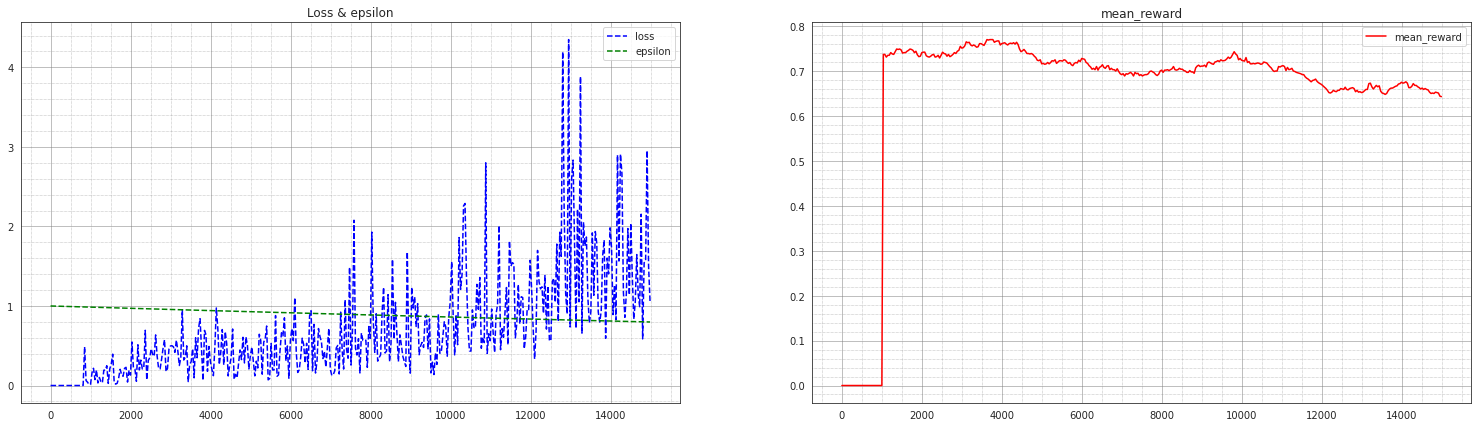

game_episode: 000000015100, turn: 0355693, epsilon: 0.797, mean reward: 0.638, loss: 1.8462, last reward 1.0, episodes time: 21.2006 sec
game_episode: 000000015200, turn: 0358045, epsilon: 0.796, mean reward: 0.639, loss: 1.9335, last reward 1.0, episodes time: 17.4696 sec
game_episode: 000000015300, turn: 0360369, epsilon: 0.795, mean reward: 0.638, loss: 4.3230, last reward 1.0, episodes time: 16.7387 sec
game_episode: 000000015400, turn: 0362777, epsilon: 0.794, mean reward: 0.640, loss: 3.3804, last reward 1.0, episodes time: 17.2215 sec
game_episode: 000000015500, turn: 0364923, epsilon: 0.793, mean reward: 0.645, loss: 3.4788, last reward 0, episodes time: 16.1506 sec
game_episode: 000000015600, turn: 0367281, epsilon: 0.791, mean reward: 0.658, loss: 1.4846, last reward 1.0, episodes time: 17.2891 sec
game_episode: 000000015700, turn: 0369637, epsilon: 0.790, mean reward: 0.656, loss: 0.6520, last reward 0, episodes time: 17.3286 sec
game_episode: 000000015800, turn: 0371965, ep

In [ ]:
# optimizer = keras.optimizers.Adam(learning_rate=0.00025) # added back clipnorm (was deleted)
# loss_funct = tf.keras.losses.Huber(delta=1.2)   # changet at epoch 1100 from 1.3
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
# optimizer = keras.optimizers.SGD(learning_rate=learning_rate,
#                                   momentum=0.9,
#                                   nesterov=True) # added back clipnorm (was deleted
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# loss_funct = tf.keras.losses.Huber()
loss_funct = tf.keras.losses.MSE

model.compile(optimizer = optimizer,
              loss = loss_funct)

model_target.compile(optimizer = optimizer,
                    loss = loss_funct)

best_mean_reward = None
num_actions = 37
loss_numpy = 0
loss = 0
total_games_count = 0
start_datetime = datetime.now(timezone)
print(">>>Training starts at ", start_datetime)
game_table.prepare_new_game()
ai_repeat = 'new'
start_time = time.time()
episodes_start_time = time.time()
while True:
#         game_table.verbose = True
        if ai_repeat == 'new':
            game_table.first_game = True
            game_table._reset()
        epsilon = max(epsilon*eps_decay, eps_min)
        reward, episode_buffer = game_table.train_episode_AI(start_type=ai_repeat, nnmodel=model, epsilon=epsilon)
        reward = np.float16(reward)

        if game_table.episode_players_ranks[0] != 1:
            ai_repeat == 'new'
        else:
            ''' 
            if computer player wins (NOT AI)
            we are add game episode to buffer but 
            replay same game until AI players win
            '''
            ai_repeat == 'same'
            reward = 0
        
        game_table.replay_buffer.extend(episode_buffer)

        game_episode += 1
        total_games_count +=1
        turn_idx += game_table.game_turns
        total_rewards.append(reward)
        if len(total_rewards) > 1000:
          mean_reward = np.mean(total_rewards[-1000:])
          del total_rewards[:1]
        msg = f"\rgame_episode: {game_episode:012d}, turn: {turn_idx:07d}, epsilon: {epsilon:.3f}, " \
              f"mean reward: {mean_reward:.3f}, loss: {loss_numpy:.4f}, " \
              f"last reward {reward}"

        if (best_mean_reward is None or best_mean_reward < mean_reward) \
          and game_episode > 1000:
            best_mean_reward = mean_reward
            if best_mean_reward is not None:
                msg = f'{msg}. Best mean reward updated {best_mean_reward:.3f}'
                msg_display = True

        if mean_reward > MEAN_REWARD_BOUND \
          and len(game_table.replay_buffer) > replay_start_size \
          and epsilon == 0.02:
            end_time = time.time()
            game_time = end_time - start_time 
            start_time  = time.time()
            print(f'{msg}, time: {game_time:.4f} sec')    
            print("Solved in %d turns!" % turn_idx)
            if tf.is_tensor(loss):
                loss_numpy = tf.keras.backend.get_value(loss)
            df = add_data_to_pd(df, game_episode, turn_idx, game_time, loss_numpy, epsilon, mean_reward)
            df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
            break
        end_time = time.time()
        game_time = end_time - start_time 
        start_time  = time.time()
        if tf.is_tensor(loss):
            loss_numpy = tf.keras.backend.get_value(loss)    
        if game_episode % 100 == 0 or msg_display:
          episodes_end_time = time.time()
          episodes_time = episodes_end_time - episodes_start_time 
          episodes_start_time  = time.time() 
          print(f'{msg}, episodes time: {episodes_time:.4f} sec')
          msg_display = False
        df = add_data_to_pd(df, game_episode, turn_idx, game_time, loss_numpy, epsilon, mean_reward)
        if (game_episode % 500 == 0) and (game_episode != 0):
            df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
        if (game_episode % 2000 == 0) and (game_episode != 0) and (turn_idx >= replay_start_size):
            print('Saving weights...')
            model.save_weights(os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
            game_table.replay_buffer.save(exp_file_path)

        if game_episode % 2500 == 0:
            figshow(df)
        if (game_episode % 15000 == 0) and (game_episode != 0):  
            clear_output()
            print(df.tail(50).to_string())
            figshow(df)

        if len(game_table.replay_buffer) < replay_start_size:
            continue

        batch = game_table.replay_buffer.sample(batch_size)
        states, actions, rewards, dones, next_states = batch

        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        # Build the updated Q-values for the sampled future states
        # Use the target model for stability
        next_states_values = model_target.predict(next_states)
        # Q value = reward + discount factor * expected future reward

        next_states_values = tf.reduce_max(next_states_values, axis=1)

        next_states_values = next_states_values * gamma + rewards

        # If final turn set the last value to -1
        ''' Why? cos we must have a zero at this value '''
        # updated_q_values = updated_q_values * (1 - dones) - dones
        expected_state_action_values = next_states_values * (1 - dones)

        # Create a mask so we only calculate loss on the updated Q-values
        masks = tf.one_hot(actions, num_actions)
        # tf.print(masks)

        with tf.GradientTape() as tape:
            # Train the model on the states and updated Q-values
            state_action_values = model(states)

            # Apply the masks to the Q-values to get the Q-value for action taken

            state_action_values = tf.reduce_sum(tf.multiply(state_action_values, masks), axis=1)
            # print('updated_q_values')
            # with np.printoptions(precision=3, suppress=True):
            #     print(updated_q_values.numpy())
            # print('q-action')
            # with np.printoptions(precision=3, suppress=True):
            #     print(q_action.numpy())
            # Calculate loss between new Q-value and old Q-value
            loss = loss_funct(state_action_values, expected_state_action_values)
            # loss = loss_funct(expected_state_action_values, state_action_values)

        # Backpropagation
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if game_episode % sync_target_games == 0:
            # update the the target network with new weights
            # print("Synchronizing models...")
            model_target.set_weights(model.get_weights())

print('Saving weights...')
model.save_weights(os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
game_table.replay_buffer.save(exp_file_path)
figshow(df)

end_datetime = datetime.now(timezone)
print(">>>Training ends at ", end_datetime)
train_time = end_datetime-start_datetime
print(f'Model trained:', train_time)


## Сыграем эпизод обученной моделью и воспроизведем видео

In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1 
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # создает вирт.дисплей в памяти(нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?" 
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой
 
# from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = gym.wrappers.Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
 
def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
  else:                           # если путь не нашелся 
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
DEFAULT_ENV_NAME ='Pong-v0'
def play_episode(model): # подаем на вход функции модель нейросети
    FPS = 25
    env = make_env(DEFAULT_ENV_NAME)
    env = wrapEnv(env)              # создаем среду в режиме записи
    
    done = False                       # игровой эпизод не завершён
    # observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    # newObservation = observation       # задали новое состояние которое наблюдает агент
    state = env.reset()
    total_reward = 0.0
    while done == False:               # пока игровой эпизод не завершён
        start_ts = time.time()
        env.render() 
        state_a = np.array(state, copy=False)
        state_tensor = tf.convert_to_tensor(state_a)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model.predict(state_tensor)
        # Take best action
        action = tf.argmax(action_probs[0]).numpy()

        state, reward, done, _ = env.step(action)
        total_reward += reward

        if done:
            break
        delta = 1/FPS - (time.time() - start_ts)
        if delta > 0:
            time.sleep(delta)
        # env.render()                   # запускаем воспроизведение среды
    env.close() # закрываем игровую среду после окончания игры
    print(f'Total reward: {total_reward:.2f}')
    showVideo() # показать видео игры

In [ ]:
# Взглянем как сыграет сетка, обученная на 1910 тренировках
# model.load_weights(os.path.join(HOME, f'{model_weights_save_name}_1140.h5')) # подгружаем модель из сохранённых
play_episode(model)                     # запускаем игровой эпизод

Total reward: 17.00
